# Dataset Class

In [1]:
import torch
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from  Dataset.visualize_keypoint import *
from src.dataload import *
import warnings
warnings.filterwarnings("ignore")

In [30]:
# cow sheep horse cat dog
labels = ['dog', 'cat', 'sheep', 'horse', 'cow']

class AnimalPoseDataset(Dataset):
    def __init__ (self, json_file, root_dir, transform=None):
        self.keypoints_frame = json.load(open(json_file))
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.keypoints_frame["annotations"])
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        anno_dict = self.keypoints_frame
        
        image_map = anno_dict["images"]
        annotations = anno_dict["annotations"]

        imagename = image_map[str(annotations[idx]["image_id"])]
        bbox = annotations[idx]["bbox"]
        keypoints = annotations[idx]["keypoints"]
        label = labels[annotations[idx]["category_id"]-1]
        image_path = os.path.join(self.root_dir, imagename)
        image = cv2.imread(image_path)
        sample = {'image': image, 'keypoints': keypoints, 'bbox':bbox, 'label':label}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample
    
    def draw(self, sample):
        image = sample['image']
        bbox = sample['bbox']
        xmin, ymin, xmax, ymax = bbox 
        image = draw_bbox(image, xmin, ymin, xmax, ymax, random_color())
        image = draw_keypoint(image, sample['keypoints'])
        return image


# Adversarial SDA transform

In [12]:
TOLERANCE = 20
class Rescale (object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__ (self, sample):
        image, keypoints, bbox = sample['image'], sample['keypoints'], sample['bbox']
        h, w = image.shape[:2]

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
        # scale the image
        img = transform.resize(image, (new_h, new_w))
        # scale the keypoints
        scaled_keypoints = []
        for kp in keypoints:
            new_x = int(kp[0] * new_w / w)
            new_y = int(kp[1] * new_h / h)
            scaled_keypoints.append([new_x, new_y, kp[2]])
        # scale the bbox
        xmin, ymin, xmax, ymax = bbox
        xmin = int(xmin * new_w / w)
        xmax = int(xmax * new_w / w)
        ymin = int(ymin * new_h / h)
        ymax = int(ymax * new_h / h)
        bbox = [xmin, ymin, xmax, ymax]
        

        return {'image': img, 'keypoints': scaled_keypoints, 'bbox':bbox, 'label':sample['label']}
        



class SDA(object):
    def __init__(self, nb_bodyparts):
        # number of body parts to add to the image
        self.nb_bodyparts = nb_bodyparts

    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        image, keypoints, bodyparts = self.crop_bodypart(image, keypoints)
        return {'image': image, 'keypoints': keypoints, 'bodyparts': bodyparts}

    def crop_bodypart(self, image, keypoints):
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        draw_keypoint(mask, keypoints)
        # find the contours in the mask
        contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # crop the different body parts and store them 
        bodyparts = []
        for i in range(len(contours)):
            x,y,w,h = cv2.boundingRect(contours[i])
            bodyparts.append(image[y-TOLERANCE:y+h+TOLERANCE, x-TOLERANCE:x+w+TOLERANCE])
        # return the image with the body parts and the keypoints

        return image, keypoints, bodyparts

# Dataloader


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6117
[[86, 102, 1], [43, 99, 1], [57, 184, 1], [88, 65, 1], [53, 65, 1], [131, 340, 1], [83, 337, 1], [258, 327, 1], [183, 327, 1], [132, 336, 1], [80, 344, 1], [259, 330, 1], [185, 335, 1], [120, 433, 1], [101, 426, 1], [261, 419, 1], [162, 414, 1], [84, 217, 1], [110, 107, 1], [0, 0, 0]]


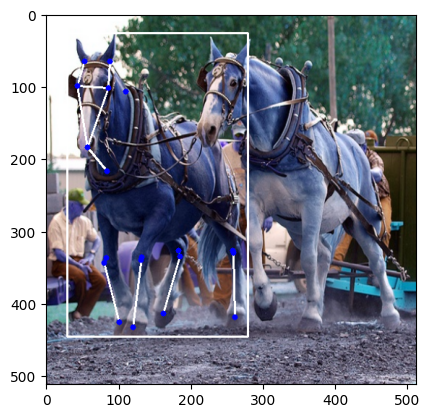

In [32]:
sda = SDA(nb_bodyparts=4)

dataset = AnimalPoseDataset(json_file='Dataset/keypoints.json', 
                            root_dir='Dataset/images/',
                            transform=transforms.Compose([Rescale((512,512))]))
print(dataset.__len__())
index = 2002
data = dataset.__getitem__(index)
print(data['keypoints'])

# show the image with the keypoints
plt.figure()
plt.imshow(dataset.draw(data))
plt.show()



In [35]:
dataloader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=0)

print(len(dataloader))

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(), sample_batched['label'])
    if i_batch == 10:
        break


612
0 torch.Size([10, 512, 512, 3]) ['cow', 'dog', 'sheep', 'sheep', 'cow', 'cat', 'cat', 'cat', 'cow', 'sheep']
1 torch.Size([10, 512, 512, 3]) ['dog', 'cat', 'dog', 'dog', 'cow', 'sheep', 'cat', 'cat', 'sheep', 'sheep']
2 torch.Size([10, 512, 512, 3]) ['dog', 'dog', 'cow', 'cat', 'dog', 'cat', 'horse', 'horse', 'cat', 'cat']
3 torch.Size([10, 512, 512, 3]) ['sheep', 'cat', 'cat', 'cat', 'dog', 'cow', 'sheep', 'sheep', 'sheep', 'dog']
4 torch.Size([10, 512, 512, 3]) ['dog', 'horse', 'dog', 'horse', 'cow', 'horse', 'cat', 'cat', 'cat', 'dog']
5 torch.Size([10, 512, 512, 3]) ['cat', 'cat', 'dog', 'horse', 'dog', 'horse', 'sheep', 'sheep', 'dog', 'dog']
6 torch.Size([10, 512, 512, 3]) ['sheep', 'sheep', 'cat', 'sheep', 'cow', 'dog', 'cat', 'cow', 'horse', 'horse']
7 torch.Size([10, 512, 512, 3]) ['horse', 'cow', 'dog', 'horse', 'dog', 'horse', 'cat', 'sheep', 'dog', 'cow']
8 torch.Size([10, 512, 512, 3]) ['dog', 'dog', 'horse', 'cat', 'dog', 'cow', 'cow', 'dog', 'cat', 'cat']
9 torch.Siz